# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Package setup

In [1]:
# Basic packages
import time
import random
import numpy as np
import pandas as pd
import sys
import os

# Math packages
import math
from scipy.signal import spectrogram

# Plot packages
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

# ML Packages
from sklearn.model_selection import KFold


#Import your modules
#---------------------------------------
import admin_functions as adfn

# Packages & self-implemented functions
from CTK_net import *

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

## Model settings 

In [24]:
class CTKNet_CNN_1(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CNN_1, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [10, 3]
        pool_kernel = [2, 2]
        fc_unit = [128]
        drop_out = [0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[1])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x

In [16]:
class CTKNet_CNN_2(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CNN_2, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [20, 10, 5]
        conv_kernel = [3, 5, 10]
        pool_kernel = [1, 2, 2]
        fc_unit = [128, 64]
        drop_out = [0.5, 0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        self.conv3 = nn.Conv2d(in_channels = conv_channel[1], out_channels = conv_channel[2], kernel_size = conv_kernel[2])
        # self.bn3 = nn.BatchNorm2d(conv_channel[2])
        self.pool3 = nn.MaxPool2d(kernel_size = pool_kernel[2])
        img_size = np.floor((img_size - conv_kernel[2] + 1.0) / pool_kernel[2])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[2])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = fc_unit[1])
        self.drop2 = nn.Dropout(drop_out[1])
        
        self.fc3 = nn.Linear(in_features = fc_unit[1], out_features = out_size[0])

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        # x = self.bn3(x)
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.drop2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x

In [2]:
class CTKNet_RNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_RNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = [64]
        drop_out = [0.5]
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        fc_input_size = np.int(np.prod(img_size) * input_shape[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x

In [3]:
class CTKNet_CRNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CRNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(3, 3), (3, 3)]
        pool_kernel = [(1, 1), (1, 1)]
        rnn_layer = [1]
        rnn_unit = [64]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - np.array(conv_kernel[0]) + 1.0) / np.array(pool_kernel[0]))
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - np.array(conv_kernel[1]) + 1.0) / np.array(pool_kernel[1]))
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None)   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x

In [5]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models

## Input settings - hyperparameters

In [6]:

class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction

In [18]:
# General settings
workspace_dir = Fdata  + 'EMOTION-HEALTHY/'  # Workspace directionary

LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [24, 25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None

Current device: cpu
Random seed 2021 has been set.


In [7]:
# General settings
workspace_dir = Fdata  + 'EMOTION-HEALTHY/'  # Workspace directionary

LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 50 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None

Current device: cpu
Random seed 2021 has been set.


# Data sort

In [19]:

# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])

Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


# Run

In [25]:
CTK_Net_select = CTKNet_CNN_1

# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_Net_select(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])

CTKNet_CNN_1(
  (conv1): Conv2d(14, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5655, out_features=128, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11239904761314393 0.11184770707041025 0.13221765717580206
Train/Val/TEST Accuracy: 43.47826086956522 50.0 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08690171241760254 0.10555527607599895 0.13884781673550606
Train/Val/TEST Accuracy: 52.17391304347826 50.0 38.095238095238095
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.13671641051769257 0.13899886649515894 0.16187828526844464
Train/Val/TEST Accuracy: 62.31884057971015 44.44444444444444 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09278012812137604 0.1377426241007116 0.12824942632800057
Train/Val/TEST Accuracy: 47.82608695652174 38.888888888888886 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.10149864405393601 0.12371046328917146 0.1418833596011003
Train/Val/TEST Accuracy: 46.3768115942029 38.888888888888886 19.047619047619047
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09052705764770508 0.09014746244065464 0.13474247329646633
Train/Val/TEST Accurac

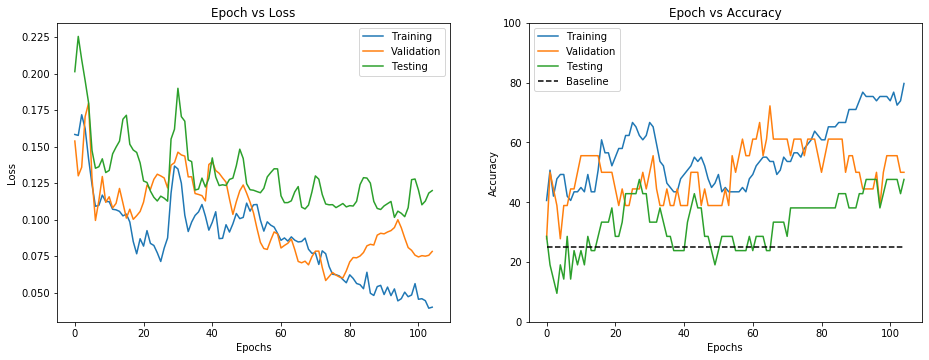

Train/Val/Test Final MSE: [0.07664982080459595, 0.058297184839223824, 0.1106956662787568]
Train/Val/Test Maximum Accuracy: [56.52173913043478, 61.111111111111114, 38.095238095238095]

2/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07622701376676559 0.12603629789211684 0.13896701054736263
Train/Val/TEST Accuracy: 63.768115942028984 22.22222222222222 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.049199362844228746 0.1362347467414414 0.13421749013165632
Train/Val/TEST Accuracy: 81.15942028985508 27.77777777777778 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04772424623370171 0.13637837881429327 0.11998225371575072
Train/Val/TEST Accuracy: 84.05797101449275 50.0 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0816364374011755 0.14504326093528006 0.17993916376006036
Train/Val/TEST Accuracy: 71.01449275362319 44.44444444444444 38.095238095238095
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08077077567577362 0.12239114378785922 0.1337292328299511
Train/Val/TEST Accuracy: 71.01449275362319 27.77777777777778 42.857142857142854
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06353419348597526 0.15437949697176614 0.1292094425520017
Train/Val/

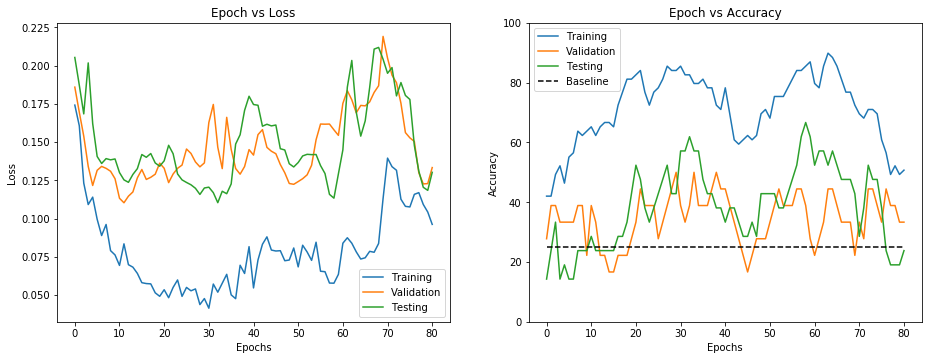

Train/Val/Test Final MSE: [0.08077077567577362, 0.12239114378785922, 0.1337292328299511]
Train/Val/Test Maximum Accuracy: [71.01449275362319, 27.77777777777778, 42.857142857142854]

3/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.21598324179649353 0.2107696344747263 0.2050886150626909
Train/Val/TEST Accuracy: 91.42857142857143 88.23529411764706 90.47619047619048
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.21021761000156403 0.2101002085734816 0.20559340502534593
Train/Val/TEST Accuracy: 92.85714285714286 82.3529411764706 90.47619047619048
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.1991672247648239 0.2078516794478192 0.20436387047881172
Train/Val/TEST Accuracy: 90.0 82.3529411764706 90.47619047619048
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.1897067129611969 0.20680743675021565 0.20266086501734598
Train/Val/TEST Accuracy: 72.85714285714286 58.8235294117647 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.20084872245788574 0.203177310526371 0.20328334541547866
Train/Val/TEST Accuracy: 85.71428571428571 82.3529411764706 90.47619047619048
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.23088017404079436 0.26907244149376364 0.24938406085684187
Train/Val/TEST Accuracy:

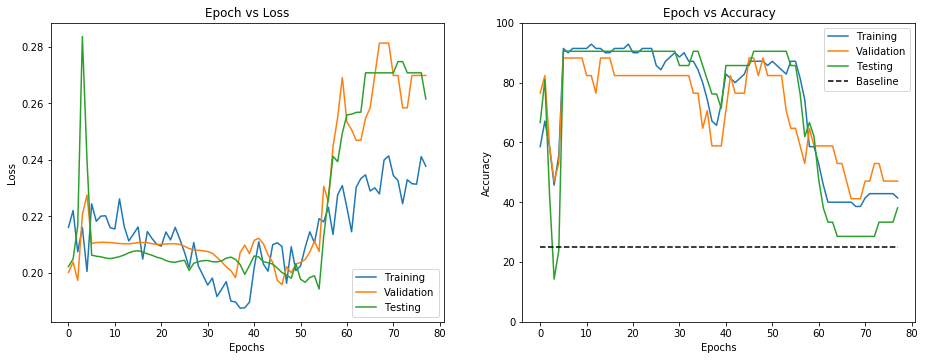

Train/Val/Test Final MSE: [0.20938381552696228, 0.19590433336356106, 0.2001708848845391]
Train/Val/Test Maximum Accuracy: [87.14285714285714, 88.23529411764706, 90.47619047619048]

4/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.16046744883060454 0.21135451633702307 0.24478924394186055
Train/Val/TEST Accuracy: 42.857142857142854 41.1764705882353 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07588779181241989 0.15016660998191902 0.13867850486366523
Train/Val/TEST Accuracy: 67.14285714285714 41.1764705882353 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04944201931357384 0.22571308264399276 0.16111966790187926
Train/Val/TEST Accuracy: 80.0 35.294117647058826 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.053339320421218875 0.16511315090910478 0.17022924071976117
Train/Val/TEST Accuracy: 85.71428571428571 47.05882352941177 42.857142857142854
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.06825569570064545 0.21573420646874344 0.2582325499859594
Train/Val/TEST Accuracy: 77.14285714285714 47.05882352941177 33.333333333333336
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0781562238931656 0.22928397960084326 0.24766161824975694
Train/Val

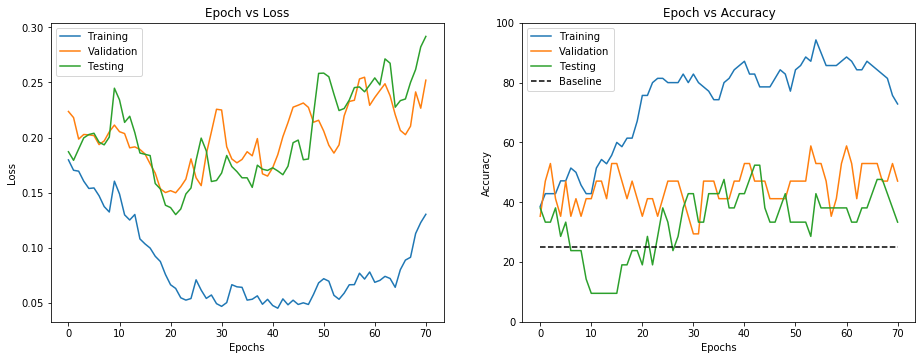

Train/Val/Test Final MSE: [0.053339320421218875, 0.16511315090910478, 0.17022924071976117]
Train/Val/Test Maximum Accuracy: [85.71428571428571, 47.05882352941177, 42.857142857142854]

5/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07340742647647858 0.1341026328942355 0.12689878623045625
Train/Val/TEST Accuracy: 64.28571428571429 41.1764705882353 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.04889009445905686 0.14445497079149766 0.17040297708341054
Train/Val/TEST Accuracy: 71.42857142857143 35.294117647058826 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.048294097557663916 0.1260709946098573 0.14081933650942074
Train/Val/TEST Accuracy: 74.28571428571429 41.1764705882353 57.142857142857146
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0478209100663662 0.13587071530192213 0.14746693801134825
Train/Val/TEST Accuracy: 74.28571428571429 41.1764705882353 57.142857142857146
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03820877969264984 0.13116435454610517 0.17222475903552203
Train/Val/TEST Accuracy: 87.14285714285714 52.94117647058823 52.38095238095238
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.04138539135456085 0.08509271301958637 0.16943330801136436

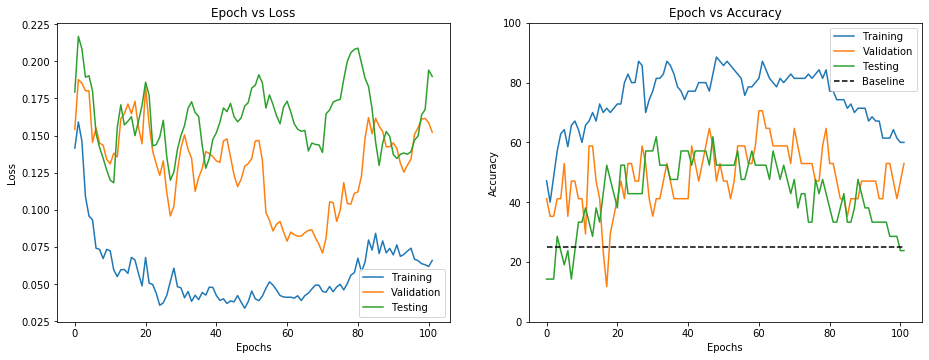

Train/Val/Test Final MSE: [0.04514925628900528, 0.07091380606460221, 0.13865800414766585]
Train/Val/Test Maximum Accuracy: [81.42857142857143, 64.70588235294117, 47.61904761904762]


In [26]:

# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)

In [21]:
CTK_Net_select = CTKNet_CNN_2

# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_Net_select(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])

CTKNet_CNN_1(
  (conv1): Conv2d(14, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4680, out_features=128, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09697835892438889 0.09178858095159133 0.1095829668587872
Train/Val/TEST Accuracy: 50.72463768115942 38.888888888888886 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07869982644915581 0.08672305119883579 0.11164681784187754
Train/Val/TEST Accuracy: 49.27536231884058 44.44444444444444 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.043528614193201066 0.08551641067283021 0.09256501586752988
Train/Val/TEST Accuracy: 72.46376811594203 50.0 38.095238095238095
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.030266759917140007 0.08104470371068197 0.083570995467848
Train/Val/TEST Accuracy: 81.15942028985508 44.44444444444444 66.66666666666667
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.029263530671596528 0.08571128339422608 0.07718396580423273
Train/Val/TEST Accuracy: 76.81159420289855 50.0 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.02855489104986191 0.08183455255089535 0.07163055670181555
Train/Val/TEST Accura

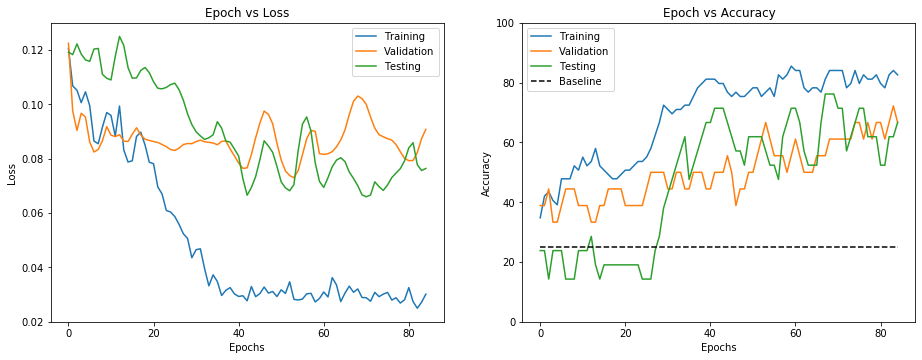

Train/Val/Test Final MSE: [0.02822258770465851, 0.0729822347768479, 0.0704718407637085]
Train/Val/Test Maximum Accuracy: [76.81159420289855, 66.66666666666667, 57.142857142857146]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09947570860385894 0.0899187927134335 0.1279163710506899
Train/Val/TEST Accuracy: 49.27536231884058 27.77777777777778 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07154443636536598 0.09392851112513906 0.11882967955344134
Train/Val/TEST Accuracy: 62.31884057971015 22.22222222222222 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04895423948764801 0.11420612057877912 0.11580254780572086
Train/Val/TEST Accuracy: 75.3623188405797 27.77777777777778 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04181481525301933 0.12077474718292554 0.10576573282568938
Train/Val/TEST Accuracy: 76.81159420289855 44.44444444444444 38.095238095238095
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.031169424206018446 0.11321930432071288 0.1039263733740275
Train/Val/TEST Accuracy: 81.15942028985508 44.44444444444444 38.095238095238095
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.036348980665206906 0.11734321718621585 0.102226750880834

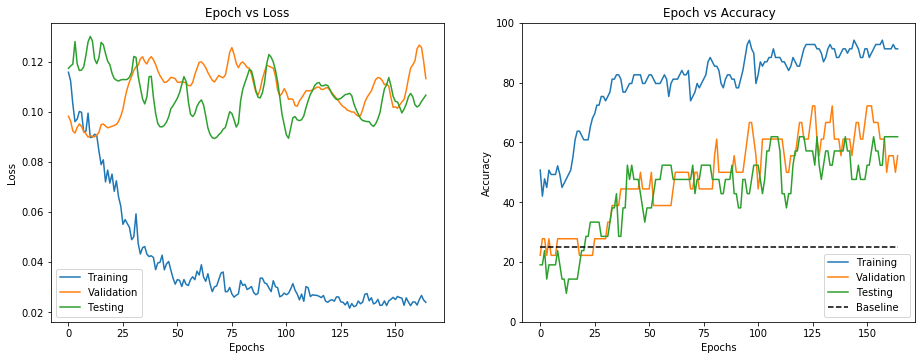

Train/Val/Test Final MSE: [0.024447260051965715, 0.0982058055491911, 0.09906616079665366]
Train/Val/Test Maximum Accuracy: [92.7536231884058, 66.66666666666667, 52.38095238095238]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09252188056707382 0.1166199629797655 0.11970722174183243
Train/Val/TEST Accuracy: 41.42857142857143 41.1764705882353 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.0810782216489315 0.11487913317978382 0.12268156977370381
Train/Val/TEST Accuracy: 44.285714285714285 52.94117647058823 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.06887357011437416 0.11578063694212366 0.11722989799454808
Train/Val/TEST Accuracy: 50.0 52.94117647058823 23.80952380952381
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.05751976892352104 0.10922090018935063 0.11598871435437884
Train/Val/TEST Accuracy: 58.57142857142857 58.8235294117647 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.043715013563632964 0.10934889530215193 0.10752056733361401
Train/Val/TEST Accuracy: 72.85714285714286 58.8235294117647 42.857142857142854
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.042807520180940625 0.10177535532206736 0.10198204387866315
Train/Val/T

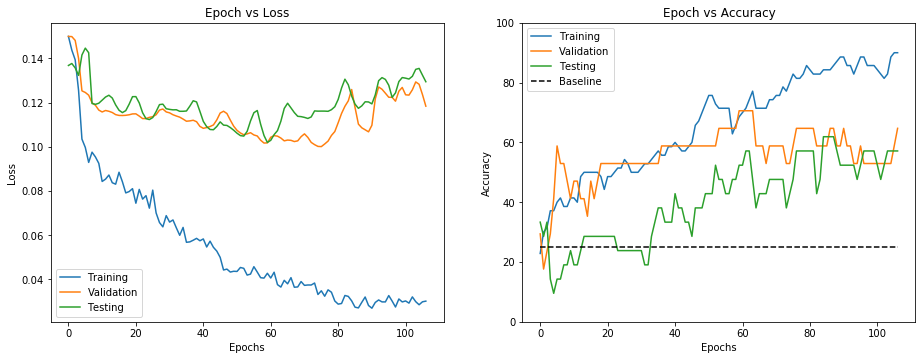

Train/Val/Test Final MSE: [0.03488497100770473, 0.10009398766081123, 0.1161542765441395]
Train/Val/Test Maximum Accuracy: [82.85714285714286, 58.8235294117647, 47.61904761904762]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09454541504383088 0.1157033253899392 0.1145037654787302
Train/Val/TEST Accuracy: 48.57142857142857 41.1764705882353 9.523809523809524
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08205802887678146 0.12128642409601632 0.12462595553093013
Train/Val/TEST Accuracy: 45.714285714285715 41.1764705882353 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.06551061123609543 0.12780848222182078 0.11422437750956133
Train/Val/TEST Accuracy: 48.57142857142857 29.41176470588235 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04851109459996224 0.12595719635924874 0.10895144899508782
Train/Val/TEST Accuracy: 71.42857142857143 35.294117647058826 38.095238095238095
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.040529506653547286 0.1297000427456463 0.1129606758643474
Train/Val/TEST Accuracy: 72.85714285714286 29.41176470588235 52.38095238095238
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03219940327107906 0.1021745638059014 0.11148278816558775


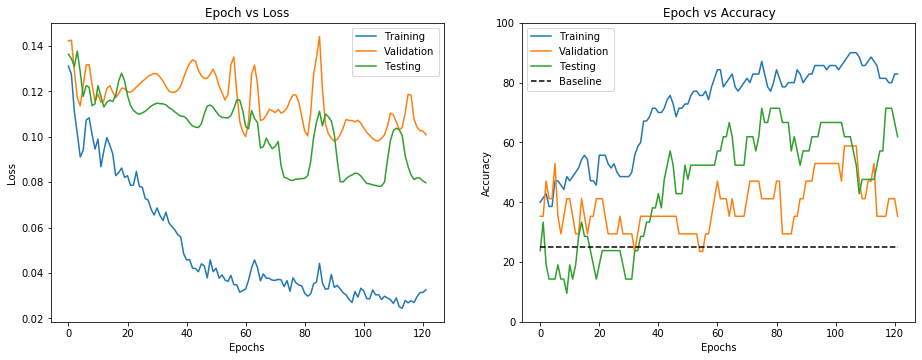

Train/Val/Test Final MSE: [0.03364390172064304, 0.09798895051319371, 0.10108651482455787]
Train/Val/Test Maximum Accuracy: [81.42857142857143, 47.05882352941177, 57.142857142857146]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.10735514611005784 0.12760193120030797 0.11893159683261599
Train/Val/TEST Accuracy: 38.57142857142857 35.294117647058826 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08761257529258729 0.11787328573272508 0.12914947659841605
Train/Val/TEST Accuracy: 42.857142857142854 35.294117647058826 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.07427698895335197 0.11141811146893922 0.1196797353304213
Train/Val/TEST Accuracy: 50.0 35.294117647058826 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.06246180608868599 0.10062424838542938 0.09534058678850886
Train/Val/TEST Accuracy: 61.42857142857143 58.8235294117647 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.041615168750286105 0.10429809264400426 0.09015893140098169
Train/Val/TEST Accuracy: 68.57142857142857 52.94117647058823 52.38095238095238
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03565569557249546 0.08640676180777304 0.09681053353207451
Train/V

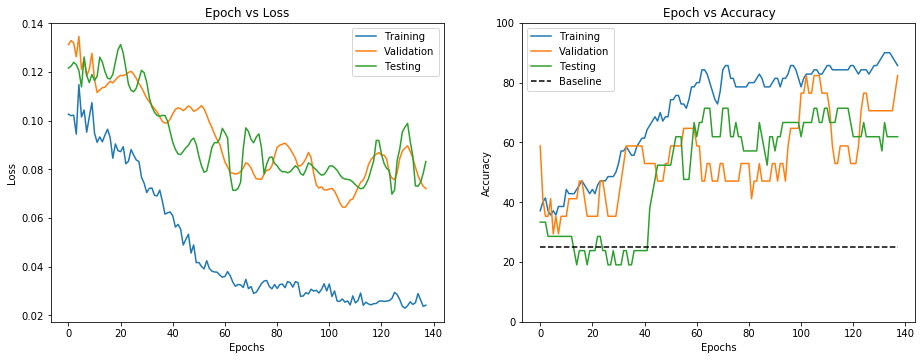

Train/Val/Test Final MSE: [0.025366705283522605, 0.06433216971345246, 0.07598166321293406]
Train/Val/Test Maximum Accuracy: [84.28571428571429, 82.3529411764706, 71.42857142857143]


In [22]:

# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)

In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.029313085153698924, 0.08672062964269929, 0.09255209122839872]
Train/Val/Test Average Accuracy: [83.62732919254658, 64.31372549019608, 57.142857142857146]


In [9]:
CTK_Net_select = CTKNet_RNN

# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_Net_select(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])

CTKNet_RNN(
  (rnn1): LSTM(90300, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1308587297797203 0.12699607035352123 0.1274259194199528
Train/Val/TEST Accuracy: 37.68115942028985 44.44444444444444 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.11399986147880554 0.10449690061310928 0.1147894405183338
Train/Val/TEST Accuracy: 42.028985507246375 50.0 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.10075430423021317 0.09177371114492416 0.11005746094243866
Train/Val/TEST Accuracy: 40.57971014492754 33.333333333333336 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.1015491932630539 0.0873470450234082 0.11115086788222903
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.10649924427270889 0.08755158374292983 0.11089709928880136
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09987692832946778 0.08886194249822034 0.11085557525179215
Train/Va

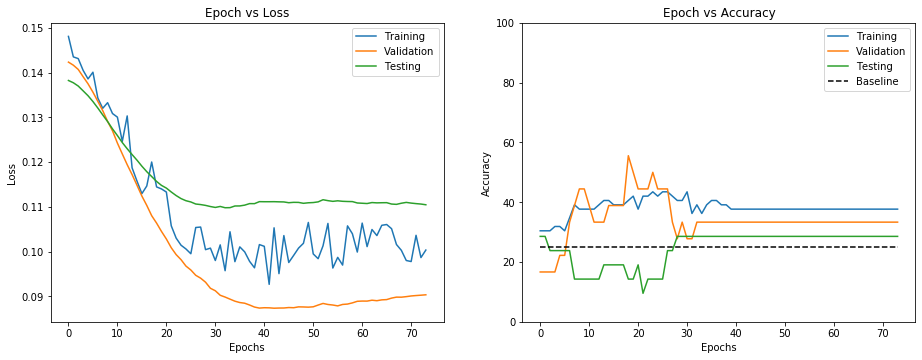

Train/Val/Test Final MSE: [0.10529830902814866, 0.08731727115809917, 0.11114495056903079]
Train/Val/Test Maximum Accuracy: [37.68115942028985, 33.333333333333336, 28.571428571428573]

2/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.14100947827100754 0.11906982047690286 0.13035449820260206
Train/Val/TEST Accuracy: 40.57971014492754 38.888888888888886 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.11255717426538467 0.09776642049352328 0.1149027610108966
Train/Val/TEST Accuracy: 46.3768115942029 16.666666666666668 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.10152440071105957 0.08946580791638957 0.10998746566474438
Train/Val/TEST Accuracy: 46.3768115942029 27.77777777777778 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09421725422143937 0.08923305767691797 0.11301154221984602
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0968247652053833 0.08790194946858618 0.11346282588229292
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09459526538848877 0.08723964707718955 0.11272735059970

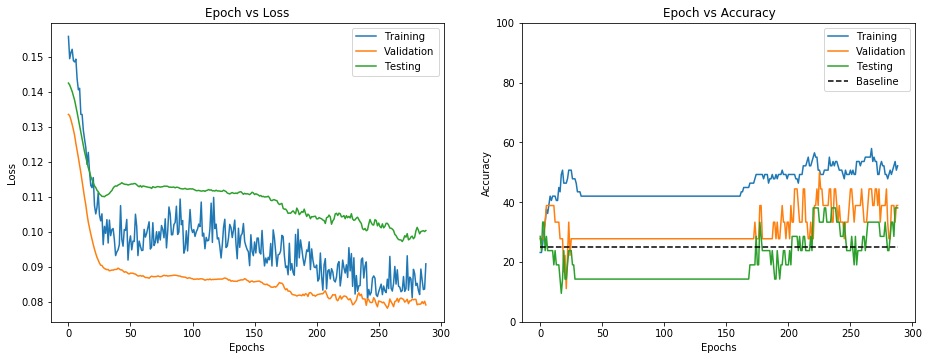

Train/Val/Test Final MSE: [0.08640950620174408, 0.07810569026817878, 0.1023808257388217]
Train/Val/Test Maximum Accuracy: [53.6231884057971, 38.888888888888886, 23.80952380952381]

3/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13097492307424546 0.14036276454434676 0.130385669923964
Train/Val/TEST Accuracy: 38.57142857142857 29.41176470588235 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10876336544752122 0.11991835758090019 0.1161527999100231
Train/Val/TEST Accuracy: 44.285714285714285 47.05882352941177 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0973163440823555 0.11245721819646218 0.11319746813249021
Train/Val/TEST Accuracy: 41.42857142857143 47.05882352941177 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08993682861328126 0.11224873637890115 0.115636045246252
Train/Val/TEST Accuracy: 41.42857142857143 35.294117647058826 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09387623965740204 0.11336092749500976 0.11518954995664812
Train/Val/TEST Accuracy: 42.857142857142854 52.94117647058823 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09360863417387008 0.11369526473914876 0.1161327974959498

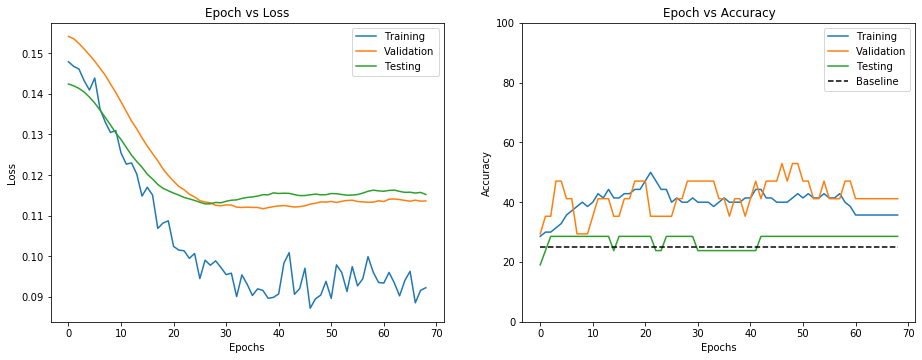

Train/Val/Test Final MSE: [0.09164557158946991, 0.1117294439498116, 0.1151854010032756]
Train/Val/Test Maximum Accuracy: [40.0, 41.1764705882353, 23.80952380952381]

4/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13097159266471864 0.1359881653505213 0.13022771034212338
Train/Val/TEST Accuracy: 35.714285714285715 35.294117647058826 9.523809523809524
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10955829918384552 0.11645844863618121 0.11644927279225417
Train/Val/TEST Accuracy: 35.714285714285715 35.294117647058826 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.1010946899652481 0.10667954889290474 0.1109519571598087
Train/Val/TEST Accuracy: 37.142857142857146 47.05882352941177 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09570065289735794 0.104469843866194 0.11166991834484395
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09382326751947404 0.1024110774126123 0.11246914514118717
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09428742229938507 0.10258685413967161 0.1132940795006496

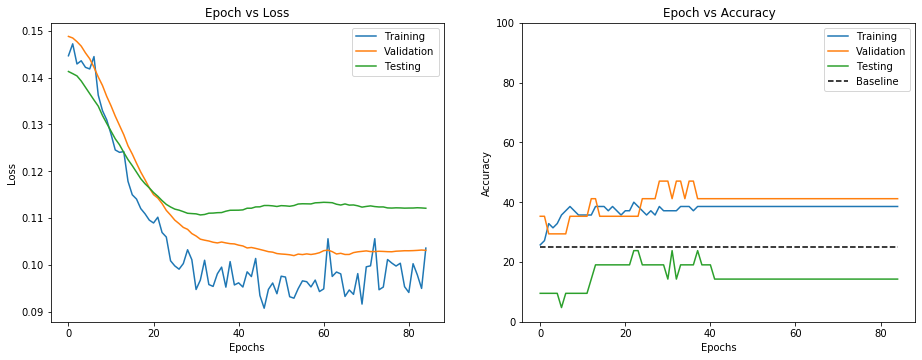

Train/Val/Test Final MSE: [0.09287199378013611, 0.10196626876645229, 0.11267201531501043]
Train/Val/Test Maximum Accuracy: [38.57142857142857, 41.1764705882353, 14.285714285714286]

5/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13101985901594163 0.15162679421551087 0.12839789218491032
Train/Val/TEST Accuracy: 50.0 23.529411764705884 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10721978396177292 0.12825101964613972 0.11358547760617166
Train/Val/TEST Accuracy: 48.57142857142857 29.41176470588235 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0962833285331726 0.11600287477759753 0.10926889947482518
Train/Val/TEST Accuracy: 47.142857142857146 29.41176470588235 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09460635483264923 0.112925774691736 0.11142744310200214
Train/Val/TEST Accuracy: 37.142857142857146 35.294117647058826 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.095179583132267 0.11277431096224223 0.11374318240476507
Train/Val/TEST Accuracy: 37.142857142857146 35.294117647058826 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09602782726287842 0.11280672537053332 0.11418836980703331
Train/

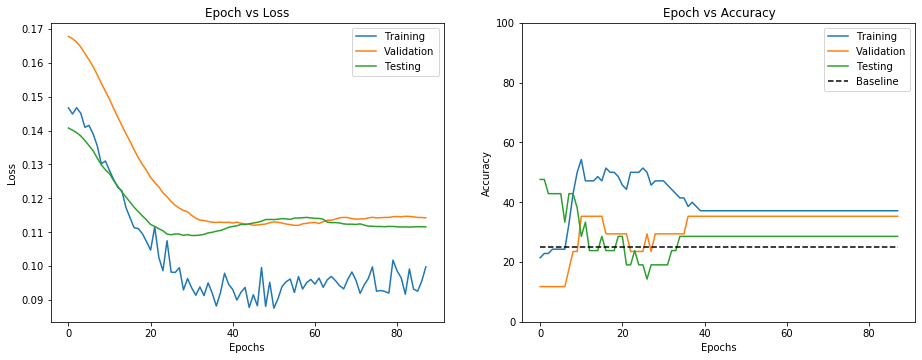

Train/Val/Test Final MSE: [0.09687824994325638, 0.111997199628283, 0.11416928736226899]
Train/Val/Test Maximum Accuracy: [37.142857142857146, 35.294117647058826, 28.571428571428573]


In [10]:

# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)

In [130]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.09806279629468918, 0.10167964306459124, 0.10360650115069889]
Train/Val/Test Average Accuracy: [37.055900621118006, 30.980392156862745, 34.28571428571429]


In [11]:
CTK_Net_select = CTKNet_CRNN

# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_Net_select(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])

CTKNet_CRNN_1(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(28750, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11450292021036149 0.11363809814469682 0.12272969367248672
Train/Val/TEST Accuracy: 44.927536231884055 50.0 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09695978611707687 0.0936188441183832 0.10969117842614651
Train/Val/TEST Accuracy: 47.82608695652174 33.333333333333336 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09475463926792145 0.08753760655721028 0.11083838330315691
Train/Val/TEST Accuracy: 47.82608695652174 38.888888888888886 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08469165116548538 0.0827410803693864 0.11392670479558763
Train/Val/TEST Accuracy: 53.6231884057971 44.44444444444444 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08423364832997322 0.08625848974204725 0.11180964564638478
Train/Val/TEST Accuracy: 52.17391304347826 44.44444444444444 19.047619047619047
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08284339904785157 0.09240056946873665 0.10477357226911754
Train/V

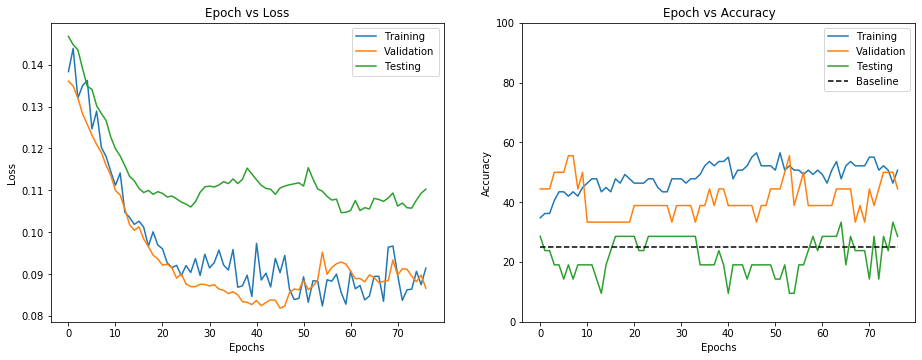

Train/Val/Test Final MSE: [0.09035002291202546, 0.0818815618339512, 0.11057577703502916]
Train/Val/Test Maximum Accuracy: [55.072463768115945, 38.888888888888886, 19.047619047619047]

2/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13167967796325683 0.11303744030495484 0.133335277260769
Train/Val/TEST Accuracy: 52.17391304347826 38.888888888888886 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09843287914991379 0.08662147323290507 0.10989456153696492
Train/Val/TEST Accuracy: 44.927536231884055 27.77777777777778 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08905852437019349 0.08530595919324292 0.11250029353513605
Train/Val/TEST Accuracy: 50.72463768115942 50.0 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08701758533716202 0.0858047152352002 0.11236886693430799
Train/Val/TEST Accuracy: 50.72463768115942 22.22222222222222 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09145279377698898 0.08476179983052942 0.1107079584506296
Train/Val/TEST Accuracy: 56.52173913043478 27.77777777777778 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08181287497282028 0.08340130860192908 0.10746915842450801
Train/Val/

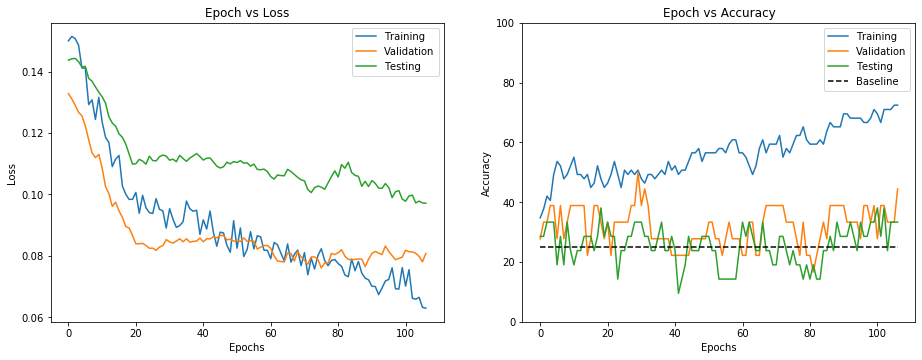

Train/Val/Test Final MSE: [0.08232324421405793, 0.0760610628252228, 0.10236560646444559]
Train/Val/Test Maximum Accuracy: [59.42028985507246, 33.333333333333336, 23.80952380952381]

3/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.10850968360900878 0.12656770734226003 0.11590324705910116
Train/Val/TEST Accuracy: 41.42857142857143 35.294117647058826 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.086616413295269 0.11337599443162188 0.10855689720206317
Train/Val/TEST Accuracy: 44.285714285714285 41.1764705882353 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08588893562555314 0.11176526699872578 0.11414720197873456
Train/Val/TEST Accuracy: 48.57142857142857 52.94117647058823 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08314732760190964 0.11397311452995329 0.1123423910965877
Train/Val/TEST Accuracy: 51.42857142857143 35.294117647058826 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08199639320373535 0.11347915889585719 0.11677172992910657
Train/Val/TEST Accuracy: 54.285714285714285 41.1764705882353 23.80952380952381
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.07155808061361313 0.11914901019019239 0.11818088209700

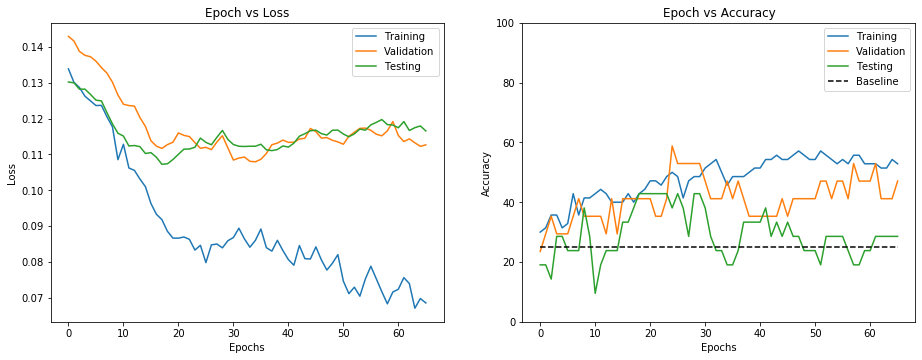

Train/Val/Test Final MSE: [0.08597701340913773, 0.10792634427985724, 0.11226507484735478]
Train/Val/Test Maximum Accuracy: [45.714285714285715, 47.05882352941177, 19.047619047619047]

4/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1105703815817833 0.12192130198373514 0.11150806397199631
Train/Val/TEST Accuracy: 44.285714285714285 41.1764705882353 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09480943232774734 0.10605984553694725 0.1088851759919808
Train/Val/TEST Accuracy: 45.714285714285715 35.294117647058826 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08354956284165382 0.09958963359103483 0.10843685672928889
Train/Val/TEST Accuracy: 52.857142857142854 29.41176470588235 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08027825802564621 0.09688372789498638 0.11454566430655264
Train/Val/TEST Accuracy: 60.0 35.294117647058826 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0713487632572651 0.09560395629309557 0.11040375337359451
Train/Val/TEST Accuracy: 54.285714285714285 41.1764705882353 19.047619047619047
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06736042276024819 0.09447189113673042 0.10781186898904187
Train/

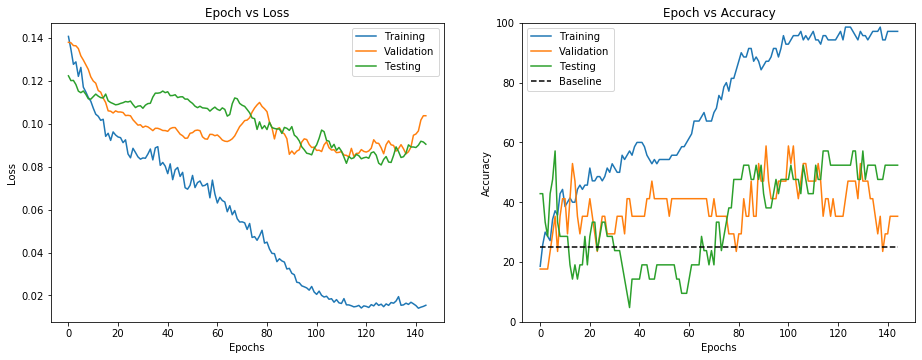

Train/Val/Test Final MSE: [0.015602715499699115, 0.0845416277537451, 0.08480375251244932]
Train/Val/Test Maximum Accuracy: [92.85714285714286, 47.05882352941177, 47.61904761904762]

5/5 Fold
----------------------------


/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1175633504986763 0.14278248653692358 0.12883104685516583
Train/Val/TEST Accuracy: 40.0 35.294117647058826 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08911908268928528 0.12352208683595937 0.11243732442103681
Train/Val/TEST Accuracy: 42.857142857142854 23.529411764705884 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08575213328003883 0.12237256173701848 0.1155572503006884
Train/Val/TEST Accuracy: 40.0 35.294117647058826 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08796217441558837 0.1219021011801327 0.11661184925053801
Train/Val/TEST Accuracy: 48.57142857142857 47.05882352941177 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09165883213281631 0.12220895991605871 0.12541700571420647
Train/Val/TEST Accuracy: 47.142857142857146 35.294117647058826 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09008709937334061 0.12202767699080355 0.11224235904713471
Train/Val/TEST Acc

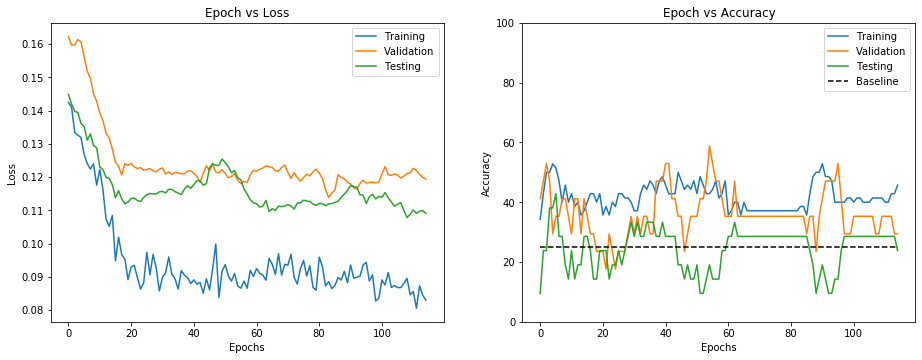

Train/Val/Test Final MSE: [0.08852130472660065, 0.11383693424217842, 0.11190620570310525]
Train/Val/Test Maximum Accuracy: [38.57142857142857, 35.294117647058826, 28.571428571428573]


In [12]:

# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)